In [1]:
!pip install pandas tensorflow scikit-learn nltk textblob


In [3]:

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout


nltk.download('vader_lexicon')

# Load the dataset
data=pd.read_csv('preprocessed_combined_clean_datasetfinal.csv')
print(data)

# Drop missing values
data.dropna(inplace=True)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                                     text sentiment  \
0                                              respond go   neutral   
1                                      SAD miss San Diego  negative   
2                                              boss bully  negative   
3                                         interview leave  negative   
4                                         son release buy  negative   
...                                                   ...       ...   
247080  wish we could come see you on denser husband l...  negative   
247081  I have wondered about rake to The client has m...  negative   
247082  say good for both of you Enjoy the break - you...  positive   
247083                          But it was worth it ****.  positive   
247084  All this flirting going on - The at smiles say...   neutral   

        text_length  
0              10.0  
1              18.0  
2              10.0  
3              15.0  
4              15.0  
...            

In [4]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import os # Import the os module
import numpy as np # Import the numpy module
# Feature engineering: Using TextBlob and Vader for polarity and sentiment analysis
data['textblob_polarity'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sia = SentimentIntensityAnalyzer()
data['vader_sentiment'] = data['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Encode the sentiment labels to integers
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


# Load pre-trained GloVe embeddings
embedding_index = {}
embedding_dim = 100  # Using 100-dimensional GloVe embeddings
# Download GloVe embeddings if not present
glove_file = 'glove.6B.100d.txt'
if not os.path.exists(glove_file):
    print("Downloading GloVe embeddings...")
    !pip install wget # Install the wget module
    import wget
    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    wget.download(url)
    # Unzip the file
    import zipfile
    with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
# Read the embeddings
print("Loading GloVe embeddings...")
with open(glove_file, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= 20000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['sentiment'], test_size=0.2, random_state=42)



  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ced20b89d28ead5510b097580be7b8186d8f5378e0bd1985e66f9dcc26ee9bca
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Loading GloVe embeddings...


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Embedding
from tensorflow.keras.models import Sequential
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model




# Define your hybrid CNN-LSTM model
model = Sequential([
    # Embedding layer
    Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False),  # Pre-trained GloVe Embeddings

    # CNN layer for feature extraction
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),

    # Use MaxPooling1D instead of GlobalMaxPooling1D to retain time steps
    MaxPooling1D(pool_size=2),  # Reduces sequence length but keeps it 3D for LSTM input

    # LSTM layer for sequence processing
    LSTM(128, return_sequences=False),  # Single LSTM layer to process sequence information

    # Dense layers for classification
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Reduced units
    Dropout(0.6),
    Dense(len(le.classes_), activation='softmax')  # Output layer
])

# Compile the model with a lower learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00001),  # Lower learning rate
              metrics=['accuracy'])

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the model
history = model.fit(X_train, y_train,
          epochs=30,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping, lr_scheduler])  # Added Early Stopping and LR Scheduler

# Save the model
model.save('cnn_lstm_model.h5')

# Save the tokenizer and label encoder (unchanged)
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Hybrid CNN-LSTM model, tokenizer, and label encoder saved successfully!")



# Predict on the test data
y_pred_proba = model.predict(X_test)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_proba, axis=1)  # Get class with highest probability

# Save the predictions and true labels to a CSV file
predictions_df = pd.DataFrame({
    'prediction': y_pred,
    'true_label': y_test.values  # Assuming y_test is a pandas Series
})

predictions_df.to_csv('cnn_lstm_predictions.csv', index=False)

print("Predictions saved to cnn_lstm_predictions.csv")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step - accuracy: 0.3913 - loss: 2.3026 - val_accuracy: 0.4051 - val_loss: 1.4851 - learning_rate: 1.0000e-05
Epoch 2/30
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - accuracy: 0.4038 - loss: 1.3796 - val_accuracy: 0.4732 - val_loss: 1.1205 - learning_rate: 1.0000e-05
Epoch 3/30
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.4880 - loss: 1.0837 - val_accuracy: 0.6001 - val_loss: 0.9494 - learning_rate: 1.0000e-05
Epoch 4/30
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - accuracy: 0.6160 - loss: 0.9374 - val_accuracy: 0.6425 - val_loss: 0.8689 - learning_rate: 1.0000e-05
Epoch 5/30
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.6517 - loss: 0.8775 - val_accuracy: 0.6457 - val_loss: 0.8552 - learning_rate: 1.0000e-05
Epoch 6/30
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.6656 - loss: 0.8478 - val_accuracy: 0.6423 - val_loss: 0.8543 - learning_rate: 1.0000e-05
Epoch 7/30
6178/6178 ━━━━━━━━━━━━━━━━━━━

Hybrid CNN-LSTM model, tokenizer, and label encoder saved successfully!
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Predictions saved to cnn_lstm_predictions.csv


In [25]:
from sklearn.metrics import classification_report

# Assuming `y_test` contains the true labels and `y_pred` contains the predicted class labels
report = classification_report(y_test, y_pred, target_names=le.classes_)

# Print the classification report
print("Classification Report for CNN-LSTM:")
print(report)


Classification Report for CNN-LSTM:
              precision    recall  f1-score   support

    negative       0.80      0.60      0.69     13810
     neutral       0.62      0.84      0.71     20021
    positive       0.84      0.64      0.73     15586

    accuracy                           0.71     49417
   macro avg       0.75      0.69      0.71     49417
weighted avg       0.74      0.71      0.71     49417



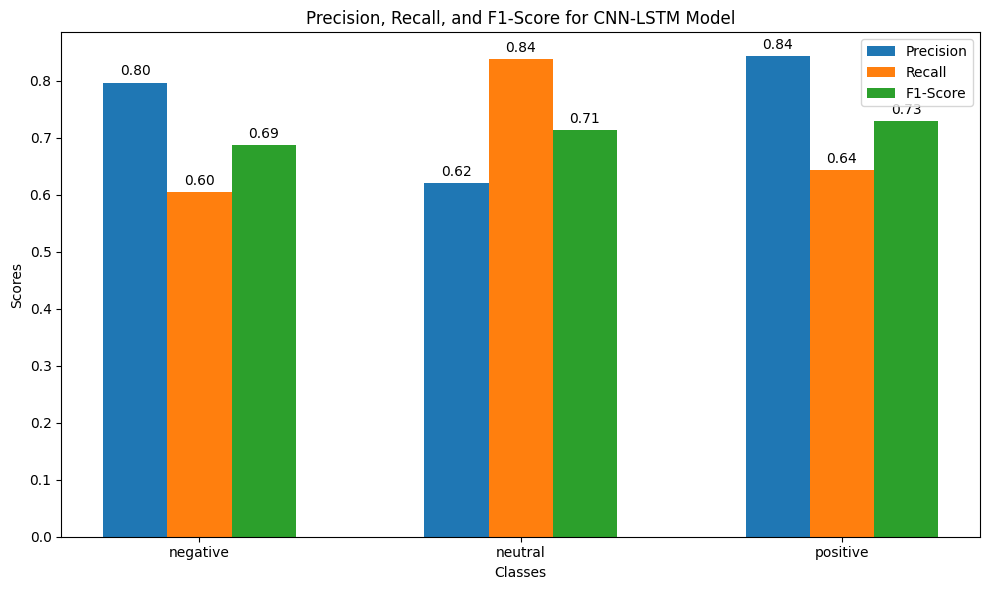

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Assuming y_test contains the true labels and y_pred contains the predicted labels
# Precision, Recall, and F1-Score for each class
precision = precision_score(y_test, y_pred, average=None)  # Precision for each class
recall = recall_score(y_test, y_pred, average=None)        # Recall for each class
f1 = f1_score(y_test, y_pred, average=None)                # F1-Score for each class

# Define class names (replace with your actual class names if different)
class_names = le.classes_

# Plot Precision, Recall, and F1-Score for each class
x = np.arange(len(class_names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each metric
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1, width, label='F1-Score')

# Add labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for CNN-LSTM Model')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Add values on top of the bars
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function for each set of bars
add_values(bars1)
add_values(bars2)
add_values(bars3)

# Show the plot
plt.tight_layout()
plt.show()


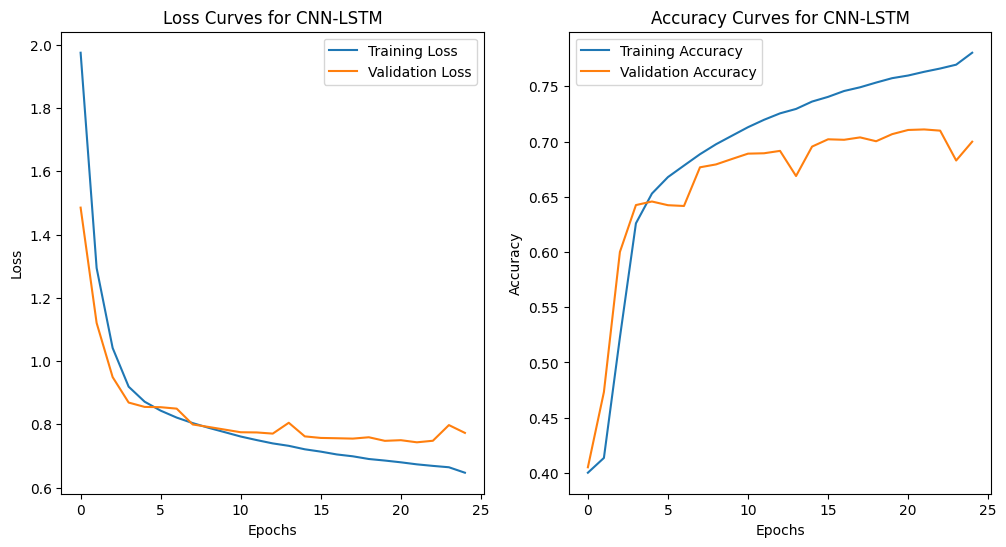

In [11]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss/Accuracy Curves
def plot_training_curves(history):
    # Loss Curves
    plt.figure(figsize=[12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves for CNN-LSTM')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves for CNN-LSTM')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

plot_training_curves(history)


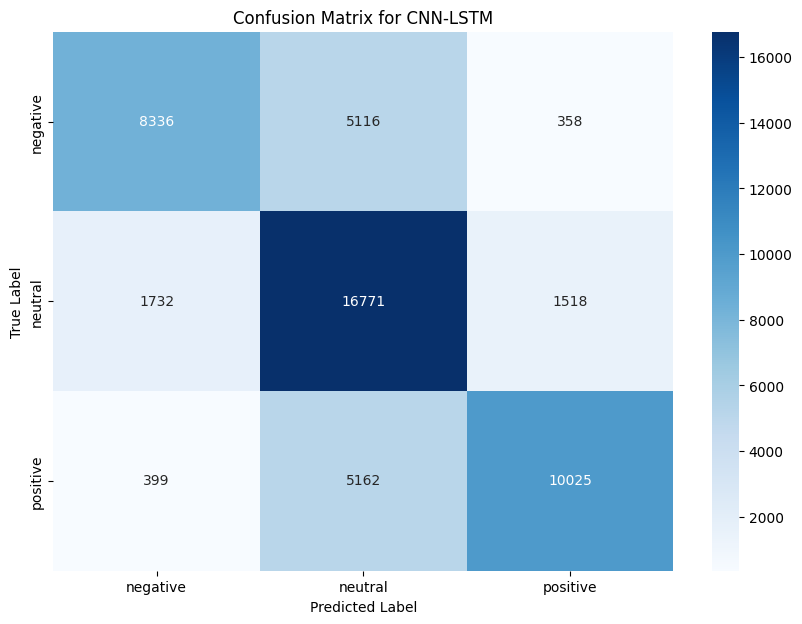

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for CNN-LSTM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


1545/1545 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


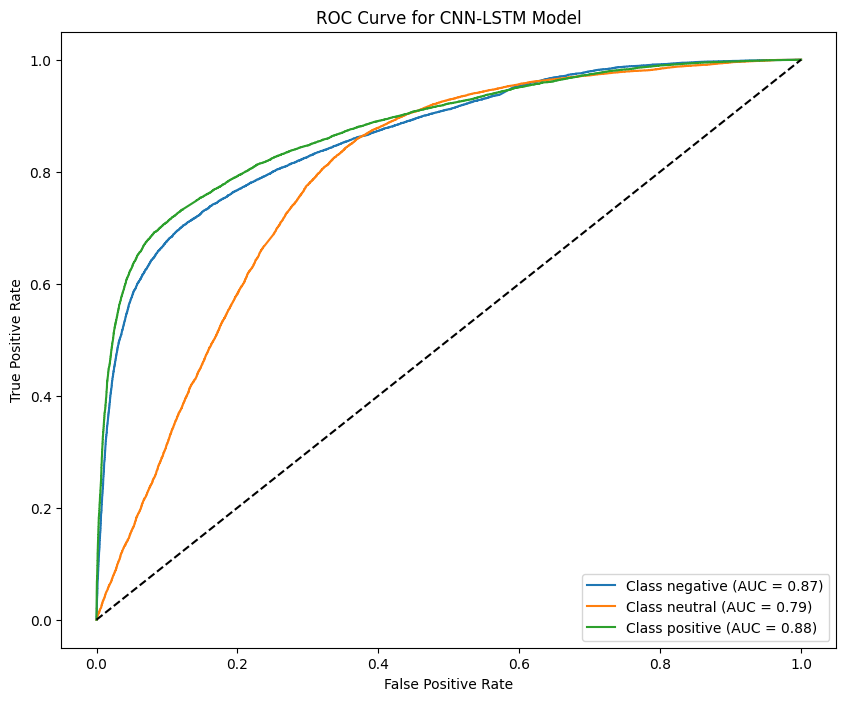

Overall AUC: 0.85


In [32]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))

# Get predicted probabilities instead of class labels
cnn_probabilities = model.predict(X_test)  # Get predicted probabilities

# Calculate ROC curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], cnn_probabilities[:, i])  # Use probabilities for each class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random chance
plt.title('ROC Curve for CNN-LSTM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Calculate overall AUC using probabilities
overall_auc = roc_auc_score(y_test_bin, cnn_probabilities, average='macro')  # Use probabilities
print(f"Overall AUC: {overall_auc:.2f}")


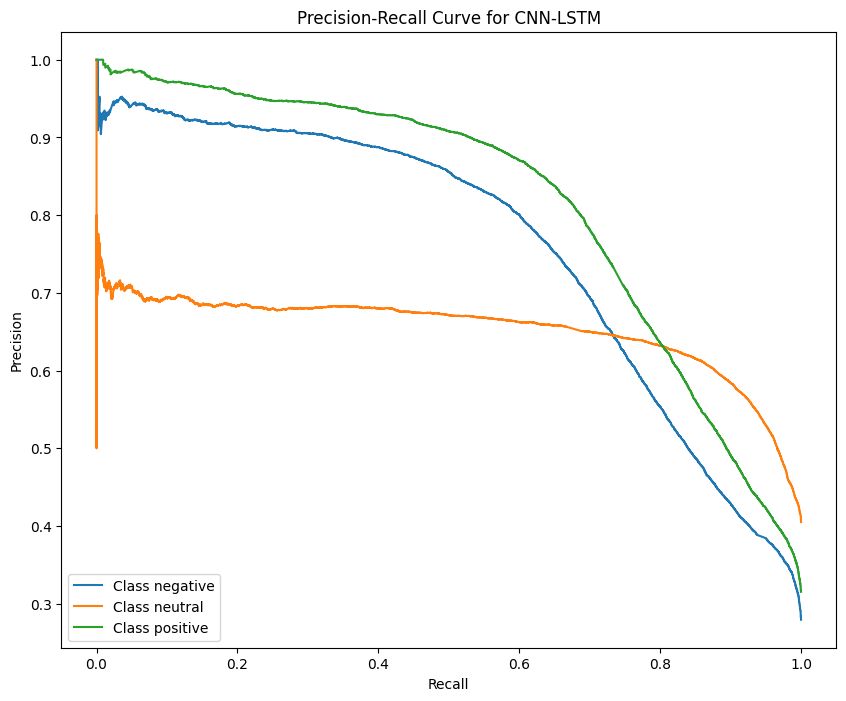

In [33]:
from sklearn.metrics import precision_recall_curve
plt.figure(figsize=(10, 8))
# Plot Precision-Recall curves
for i in range(len(le.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {le.classes_[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for CNN-LSTM')
plt.legend(loc='lower left')
plt.show()


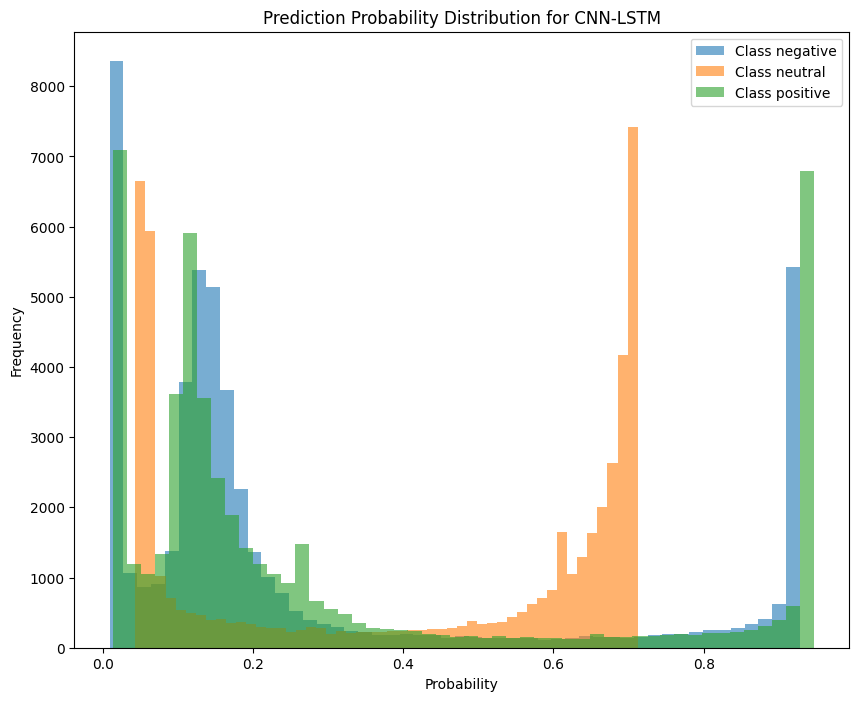

In [34]:
# Histogram of prediction probabilities
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    plt.hist(y_pred_proba[:, i], bins=50, alpha=0.6, label=f'Class {le.classes_[i]}')

plt.title('Prediction Probability Distribution for CNN-LSTM')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()



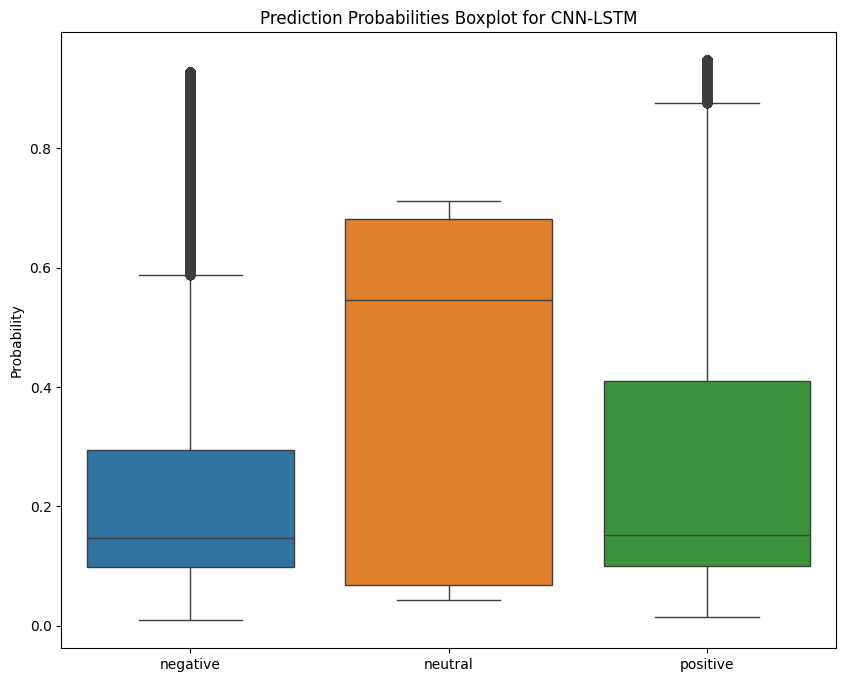

In [24]:

# Alternatively, a boxplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.boxplot(data=[y_pred_proba[:, i] for i in range(len(le.classes_))])
          # Use a color palette if desired
              # Customize line width if needed

plt.xticks(range(len(le.classes_)), le.classes_)  # Set x-axis labels
plt.title('Prediction Probabilities Boxplot for CNN-LSTM')
plt.ylabel('Probability')
plt.show()